## implementation stollen from https://blog.paperspace.com/beginners-guide-to-boltzmann-machines-pytorch/

In [150]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
def truth_func(x, y):
    #return np.logical_xor(x, y)
    return x*y
    #return np.logical_or(x, y)
    #return np.logical_not(x)

def gen_xor_training(N):
    data   = np.random.randint(0, 2, (N, 2))
    target = truth_func(data[:, 0:1], data[:, 1:2])
    return data,target

def xor_to_flat(data, target):
    concat = np.concatenate((data, target), axis=1).astype(np.single) #.flatten()
    #concat = 2*concat - 1
    return concat

def flat_to_xor(data):
    #data = data.reshape(-1, 3)
    #data = (data + 1)/2
    return data[:, 0:2], data[:, 2:3]

def xor_sucess_rate(data, target):
    ground_truth = truth_func(data[:, 0:1], data[:, 1:2])
    return 1 - np.mean(np.abs(target - ground_truth))

In [53]:
# this is a descrete RBM
class RBM(nn.Module):
   def __init__(self,
               n_vis,
               n_hin,
               k):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
   def sample_from_p(self,p):
       return torch.relu(torch.sign(p - Variable(torch.rand(p.size()))))

   def v_to_h(self,v):
        p_h      = F.sigmoid(F.linear(v, self.W, self.h_bias))
        sample_h = self.sample_from_p(p_h)
       
        return sample_h
    
   def h_to_v(self,h):
        p_v      = F.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        sample_v = self.sample_from_p(p_v)
       
        return sample_v,p_v

   def forward(self,v):
        h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            v_,p_v = self.h_to_v(h_)
            h_     = self.v_to_h(v_)
        
        return v,v_,p_v

   def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v, self.W, self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

In [121]:
batch_size = 100
n_it_train = 5
rbm = RBM(3, 4, k=n_it_train)
train_op = optim.SGD(rbm.parameters(), 0.1)

losses = []
sucess_rates = []

for epoch in range(10):
    loss_ = []
    sucess_rate_ = []
    for i in range(2000):
        data,target = gen_xor_training(batch_size)
        data_var = Variable(torch.from_numpy(xor_to_flat(data, target).astype(np.double)))
        
        v,v1,p_v1 = rbm(data_var)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        #loss = torch.abs(v - v1).mean()
        
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

        sucess_rate = xor_sucess_rate(*flat_to_xor(v1.detach().numpy()))
        sucess_rate_.append(sucess_rate)

    losses.append(np.mean(loss_))
    sucess_rates.append(np.mean(sucess_rate_))
    print("Training loss and sucess rate for {} epoch: {}, {}%".format(epoch, losses[-1], int(sucess_rates[-1]*100)))
    
print("\nv_bias:", rbm.v_bias.detach().numpy())
print("h_bias:", rbm.h_bias.detach().numpy())
print("W:\n", rbm.W.detach().numpy())

Training loss and sucess rate for 0 epoch: -0.06468089001276564, 68%
Training loss and sucess rate for 1 epoch: -0.11515953852933061, 80%
Training loss and sucess rate for 2 epoch: -0.15718189941206495, 92%
Training loss and sucess rate for 3 epoch: -0.10912007272092307, 96%
Training loss and sucess rate for 4 epoch: -0.0787729040823948, 97%
Training loss and sucess rate for 5 epoch: -0.06283275202488872, 98%
Training loss and sucess rate for 6 epoch: -0.0539113510072791, 98%
Training loss and sucess rate for 7 epoch: -0.045738351771350126, 98%
Training loss and sucess rate for 8 epoch: -0.03990378352606682, 99%
Training loss and sucess rate for 9 epoch: -0.03537231764490985, 99%

v_bias: [5.361 5.27  5.847]
h_bias: [2.41489963 5.9375695  5.60624952 2.35106134]
W:
 [[-6.63211475  2.66463927 -6.00211149]
 [-2.86129691 -3.223357   -5.21866938]
 [-3.43583047 -2.36436582 -5.13481742]
 [ 3.38961716 -7.29649412 -6.57258923]]


In [164]:
W_eigen_vect  = np.linalg.svd(rbm.W.detach().numpy()).Vh
W_eigen_vect /= W_eigen_vect.sum(1)
W_eigen_vect.sort(1) 

pca = PCA(3)
pca.fit(xor_to_flat(*gen_xor_training(1000)))
pc_data  = pca.components_
pc_data /= pc_data.sum(1)
pc_data.sort(1) 

print(W_eigen_vect)
print(pc_data)

[[-2.65785626  0.19254867  1.23894741]
 [-4.08270019 -0.4789186  -0.07700117]
 [-3.95098175 -0.75388134  0.36535587]]
[[-1.9090416e+01 -4.4474797e+00  3.1971189e-01]
 [ 4.0297750e-03  4.0177733e-01  2.5935270e+01]
 [-5.2886076e+00 -2.6855722e-01  1.6073935e+01]]


In [130]:
data,target = gen_xor_training(100)
data_var = Variable(torch.from_numpy(xor_to_flat(data, target).astype(np.double)))


n_it = 2*n_it_train

prob_traj_noFlip = np.zeros((n_it+1, 100))
prob_traj_noFlip[0, :] = data_var[:, 2]

h1 = rbm.v_to_h(data_var)
h_ = h1
for i in range(n_it):
    v_,p_v = rbm.h_to_v(h_)
    h_     = rbm.v_to_h(v_)

    prob_traj_noFlip[i+1, :] = p_v.detach().numpy()[:, 2]
prob_traj_noFlip[:, data_var[:, 2] == 0] = 1 - prob_traj_noFlip[:, data_var[:, 2] == 0]


data_var[:, 2] = 1 - data_var[:, 2]
prob_traj_flip = np.zeros((n_it+1, 100))
prob_traj_flip[0, :] = data_var[:, 2]

h1 = rbm.v_to_h(data_var)
h_ = h1
for i in range(n_it):
    v_,p_v = rbm.h_to_v(h_)
    h_     = rbm.v_to_h(v_)

    prob_traj_flip[i+1, :] = p_v.detach().numpy()[:, 2]
prob_traj_flip[:, data_var[:, 2] == 1] = 1 - prob_traj_flip[:, data_var[:, 2] == 1]

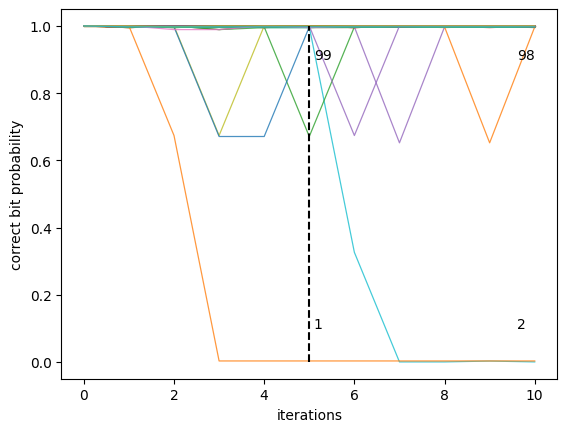

In [142]:
plt.plot(prob_traj_noFlip, linewidth=0.9, alpha=0.8)
plt.plot([5, 5], [0, 1], "k--")

n_true  = sum(prob_traj_noFlip[n_it_train, :] > 0.5)
n_false = prob_traj_noFlip.shape[1] - n_true

plt.text(n_it_train+0.1, 0.9, f"{n_true }")
plt.text(n_it_train+0.1, 0.1, f"{n_false}")

n_true_end  = sum(prob_traj_noFlip[-1, :] > 0.5)
n_false_end = prob_traj_noFlip.shape[1] - n_true_end

plt.text(n_it-0.4, 0.9, f"{n_true_end }")
plt.text(n_it-0.4, 0.1, f"{n_false_end}")

plt.xlabel("iterations")
plt.ylabel("correct bit probability")
plt.savefig('rbm_bit_stability.png')

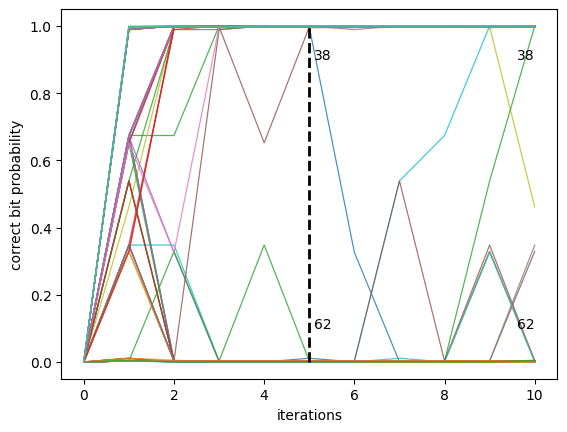

In [141]:
plt.plot(prob_traj_flip, linewidth=0.9, alpha=0.8)
plt.plot([5, 5], [0, 1], "k--", linewidth=2)

n_true = sum(prob_traj_flip[n_it_train, :] > 0.5)
n_false = prob_traj_flip.shape[1] - n_true

plt.text(n_it_train+0.1, 0.9, f"{n_true }")
plt.text(n_it_train+0.1, 0.1, f"{n_false}")

n_true_end  = sum(prob_traj_flip[-1, :] > 0.5)
n_false_end = prob_traj_flip.shape[1] - n_true_end

plt.text(n_it-0.4, 0.9, f"{n_true_end }")
plt.text(n_it-0.4, 0.1, f"{n_false_end}")

plt.xlabel("iterations")
plt.ylabel("correct bit probability")
plt.savefig('rbm_bit_correction.png')

In [56]:
#print(v.reshape(batch_size, 3)[:20, :])
print(v1.detach().numpy().reshape(batch_size, 3)[:20, :])

[[1. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


In [51]:
# Continuous RBM
class RBM_C(nn.Module):
    def __init__(self,
                n_vis,
                n_hin,
                k):
        torch.set_default_dtype(torch.double)
        super(RBM_C, self).__init__()
        
        self.W      = nn.Parameter(torch.randn(n_hin, n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
        
        self.eps=1e-3

    def v_to_h(self,v):
        p_h  = F.linear(v, self.W, self.h_bias)
        p_h_ = p_h + torch.sign(p_h)*self.eps
        p_h_[p_h_ == 0] = self.eps

        lim_up = 1 - torch.exp(-p_h_)
        lim_up = torch.clamp(lim_up, min=-1 + self.eps)
        
        y = Variable(torch.rand(p_h_.size()))*lim_up
        h = torch.log(1 - y).div(-p_h_)

        return h
    
    def h_to_v(self, h):
        p_v  = F.linear(h, self.W.t(), self.v_bias)
        p_v_ = p_v + torch.sign(p_v)*self.eps
        p_v_[p_v_ == 0] = self.eps

        lim_up = 1 - torch.exp(-p_v_)
        lim_up = torch.clamp(lim_up, min=-1 + self.eps)
        
        y = Variable(torch.rand(p_v_.size()))*lim_up
        v = torch.log(1 - y).div(-p_v_)

        return v

    def forward(self,v):
        h1 = self.v_to_h(v)
        
        h_ = h1
        for i in range(self.k):
            v_ = self.h_to_v(h_)
            h_ = self.v_to_h(v_)
        
        return v,v_
    
    def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v, self.W, self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

In [52]:
batch_size = 200
rbm = RBM_C(3, 4, k=1)
train_op = optim.SGD(rbm.parameters(), 0.01)

losses = []
sucess_rates = []

for epoch in range(20):
    loss_ = []
    sucess_rate_ = []
    for i in range(200):
        data,target = gen_xor_training(batch_size)
        data_var = Variable(torch.from_numpy(xor_to_flat(data, target).astype(np.double)))
        
        v,v1 = rbm(data_var)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()
        
        with torch.no_grad():
            rbm.v_bias[0] = 0
            rbm.v_bias[1] = 0

        sucess_rate = xor_sucess_rate(*flat_to_xor(np.round(v1.detach().numpy())))
        sucess_rate_.append(sucess_rate)

    losses.append(np.mean(loss_))
    sucess_rates.append(np.mean(sucess_rate_))
    print("Training loss and sucess rate for {} epoch: {}, {}%".format(epoch, losses[-1], int(sucess_rates[-1]*100)))
    
print("\nv_bias:", rbm.v_bias.detach().numpy())
print("h_bias:", rbm.h_bias.detach().numpy())
print("W:\n", rbm.W.detach().numpy())

Training loss and sucess rate for 0 epoch: -0.12964624397599653, 48%
Training loss and sucess rate for 1 epoch: -0.19629886128297008, 47%
Training loss and sucess rate for 2 epoch: -0.20087591047611827, 46%
Training loss and sucess rate for 3 epoch: -0.20329704699022222, 46%
Training loss and sucess rate for 4 epoch: -0.21071448009502536, 46%
Training loss and sucess rate for 5 epoch: -0.21979251830107707, 45%
Training loss and sucess rate for 6 epoch: -0.23394788026251476, 45%
Training loss and sucess rate for 7 epoch: -0.2738382017802453, 45%
Training loss and sucess rate for 8 epoch: -0.36600966759894815, 44%
Training loss and sucess rate for 9 epoch: -0.5781017066755498, 43%
Training loss and sucess rate for 10 epoch: -1.0368072038319414, 43%
Training loss and sucess rate for 11 epoch: -1.8723786627368666, 43%
Training loss and sucess rate for 12 epoch: -3.0094977122769784, 44%
Training loss and sucess rate for 13 epoch: -4.345956135815602, 46%
Training loss and sucess rate for 14 

In [50]:
print(np.round(v1.detach().numpy().reshape(batch_size, 3)[:20, :]))

[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 1. 0.]
 [0. 1. 1.]
 [1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [1. 0. 1.]
 [1. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 1. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 1.]
 [0. 1. 0.]]
